In [1]:
import torch
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import BayesianExplorationGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

vocs = tnk_vocs.copy()

# can only explore one objective
del vocs.objectives["y2"]

evaluator = Evaluator(evaluate_TNK)
generator = BayesianExplorationGenerator(vocs)
print(vocs)
print(generator.options.dict())
generator.options.n_initial = 5
generator.options.optim.num_restarts = 1
generator.options.acq.proximal_lengthscales = [1.5, 1.5]

variables={'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]} constraints={'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]} objectives={'y1': 'MINIMIZE'} constants={'a': 'dummy_constant'} linked_variables={}
{'optim': {'num_restarts': 5, 'raw_samples': 20, 'sequential': True}, 'acq': {'proximal_lengthscales': None, 'monte_carlo_samples': 512}, 'model': {}, 'n_initial': 3}


In [2]:
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.step()

for i in range(40):
    print(f"step {i}")
    X.step()

step 0
tensor([0.6643, 1.2865], dtype=torch.float64)
step 1
tensor([0.6982, 1.1003], dtype=torch.float64)
step 2
tensor([0.4075, 1.0480], dtype=torch.float64)
step 3
tensor([0.4277, 0.8490], dtype=torch.float64)
step 4
tensor([0.5903, 0.6496], dtype=torch.float64)
step 5
tensor([0.9781, 0.4699], dtype=torch.float64)
step 6
tensor([1.0758, 0.2781], dtype=torch.float64)
step 7
tensor([0.9452, 0.1070], dtype=torch.float64)
step 8
tensor([1.2076, 0.5868], dtype=torch.float64)
step 9
tensor([1.0776, 0.9412], dtype=torch.float64)
step 10
tensor([0.7460, 0.6888], dtype=torch.float64)
step 11
tensor([0.2537, 1.1695], dtype=torch.float64)
step 12
tensor([0.0376, 0.8719], dtype=torch.float64)
step 13
tensor([0.0794, 1.0022], dtype=torch.float64)
step 14
tensor([0.0573, 1.0074], dtype=torch.float64)
step 15
tensor([0.0587, 1.0136], dtype=torch.float64)
step 16
tensor([0.2932, 0.9703], dtype=torch.float64)
step 17
tensor([0.4178, 0.9203], dtype=torch.float64)
step 18
tensor([0.1916, 0.9727], dtype

In [3]:
X.data

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
1,0.536453,1.443685,dummy_constant,0.536453,1.443685,1.288960,0.891871,"[1, 2, 3]",False,
2,1.806720,2.980504,dummy_constant,1.806720,2.980504,11.223766,7.860418,"[1, 2, 3]",False,
3,1.460917,1.685124,dummy_constant,1.460917,1.685124,3.932012,2.327881,"[1, 2, 3]",False,
4,2.881497,0.147666,dummy_constant,2.881497,0.147666,7.256552,5.795667,"[1, 2, 3]",False,
5,0.600213,2.536281,dummy_constant,0.600213,2.536281,5.876818,4.156482,"[1, 2, 3]",False,
6,0.664269,1.286539,dummy_constant,0.664269,1.286539,1.073828,0.645628,"[1, 2, 3]",False,
7,0.698245,1.100346,dummy_constant,0.698245,1.100346,0.791262,0.399716,"[1, 2, 3]",False,
8,0.407484,1.047951,dummy_constant,0.407484,1.047951,0.170295,0.308810,"[1, 2, 3]",False,
9,0.427705,0.848976,dummy_constant,0.427705,0.848976,-0.134067,0.127011,"[1, 2, 3]",False,
10,0.590286,0.649570,dummy_constant,0.590286,0.649570,-0.301798,0.030523,"[1, 2, 3]",False,


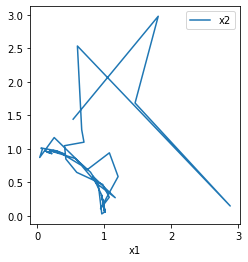

In [4]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


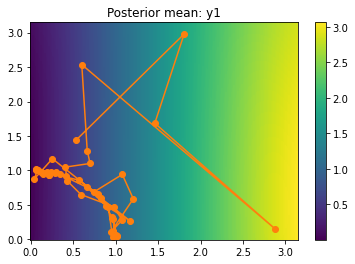

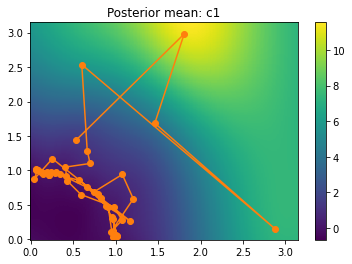

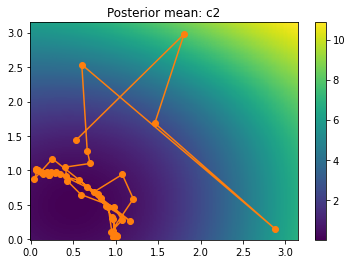

In [5]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = generator.vocs.bounds
model = generator.model

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    for i in range(mean.shape[-1]):
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "o-C1")
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n, n))
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

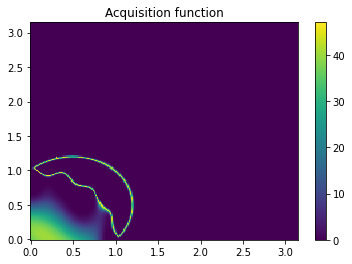

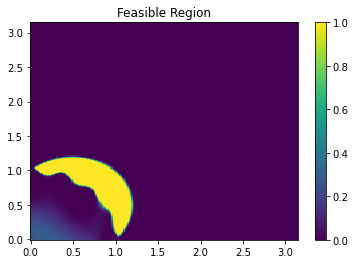

In [6]:
from xopt.generators.bayesian.utils import feasibility

acq_func = generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, generator.sampler, vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")